In [1]:
"""
This script evaluates the conditional probability starting from merger trees
"""

import matplotlib.pyplot as plt
import numpy as np
import time as t
from scipy import interpolate
from astropy.io import ascii
import h5py
from matplotlib import cm
import astropy.units as u
from astropy.cosmology import Planck15 as Planck
import os
os.environ['MKL_NUM_THREADS'] = '1' # this command prevents Python from multithreading 
import time
import random
from scipy.interpolate import interp1d
import corner
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.ticker import LogFormatter
import sys

In [2]:
def mid_creator(bin_array):
    # this function takes as input a set of bin edges (ascending order)
    # and returns as output as array of the mid values
    bin_mid = bin_array[0:len(bin_array)-1]+\
        (bin_array[1:len(bin_array)]-bin_array[0:len(bin_array)-1])/2
    return bin_mid

In [3]:
show_plots = False

In [4]:
# select the origin of the merger trees, up to now EAGLE cosmological simulation is available only
cosmo_sim = 'EAGLE'


# select the snapshot
snapshot = '28' # 28 corresponds to local Universe
gal_mass_min = '1E07' 
gal_mass_max = '1E12'
central_galaxy = '0' # 0 correspond to only central galaxies
sfr_min = '0.0001' 
sfr_max = '10000' 
N_galaxies = 'all'

z_Eagle = np.loadtxt('merger_trees/'+cosmo_sim+'/z_mid_'+cosmo_sim+'.txt',usecols=0)[28-int(snapshot):]
print(z_Eagle)

hdf5 = 'Yes'

[2.22044605e-16 1.00638539e-01 1.82709873e-01 2.70901084e-01
 3.65668565e-01 5.03107309e-01 6.15189791e-01 7.35629618e-01
 8.65050554e-01 1.00412166e+00 1.25933146e+00 1.48670733e+00
 1.73696578e+00 2.01241016e+00 2.23703694e+00 2.47841334e+00
 3.01650453e+00 3.52797651e+00 3.98366356e+00 4.48521376e+00
 5.03723669e+00 5.48741531e+00 5.97116232e+00 7.04956627e+00
 8.07461643e+00 8.98787498e+00 9.99303341e+00 1.51323109e+01
 2.00000210e+01]


In [1]:
IMF = 'Kroupa_01'

if IMF == 'Kroupa_01':
    # in this case you need to apply the rescaling
    delta_logM = +0.03
    K_IMF = 1/0.94

In [6]:
destination_in = 'merger_trees/'+cosmo_sim

destination_out = 'conditional_prob/'+cosmo_sim

if hdf5 == 'Yes':
    catalogue_filename = destination_in+'/'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_galaxies+'_'+snapshot+'.hdf5'
    # let's read the hdf5 catalogue and put info in a not nested database
    data = h5py.File(catalogue_filename, 'r')
    # number of total galaxies in the database
    N_gal = len(data.keys())
    print('Number of galaxy at redshift zero = ', N_gal)
    
    len_dset = np.zeros(N_gal+1, dtype = int)
    tot_len_dset = 0
    i = 1
    #with alive_bar(len(data.keys())) as bar:
    print('Counting the number of progenitor per each galaxy...')
    for group in tqdm(data.keys()) :
        #print(len(data[group]['MassType_Star']), '=', int(data[group]['MassType_Star'].shape[0]))
        len_dset[i] = len_dset[i-1] + data[group]['MassType_Star'].size
        tot_len_dset = tot_len_dset + data[group]['MassType_Star'].size
        i = i + 1
    print('total number of galaxies per each galaxy at any redshift = ', len_dset)
    print('total number of galaxies at any redshift = ', tot_len_dset, len_dset[N_gal])
    
    #galaxy_data_all = np.zeros((4,tot_len_dset))
    galaxy_data_progenitor =  np.zeros((4,tot_len_dset))
    galaxy_data_remnant =  np.zeros((4,N_gal))
    i = 1
    print('Saving the properties of each progenitor galaxy')
    for group_2 in tqdm(data.keys()) :
        len_dset_temp = data[group_2]['MassType_Star'].shape
        y = 0 
        for dset in ['MassType_Star', 'StarFormationRate','Redshift']:
            
            if dset == 'MassType_Star':
            
                ds_data = data[group_2][dset] # returns HDF5 dataset object
                arr = np.array(data[group_2][dset])+delta_logM 
                #galaxy_data_all[y, len_dset[i-1]:len_dset[i]] = arr
                galaxy_data_progenitor[y, len_dset[i-1]:len_dset[i]] = arr
                if arr.size != 1 :
                    #print(arr.size)
                    #print(arr)
                    galaxy_data_remnant[y, i-1] = arr[0]

                elif arr.size == 1 :
                    #print('no merger tree for ID = ', group)
                    galaxy_data_remnant[y, i-1] = arr

                else:
                    #print('no galaxy data for ID = ', group)
                    galaxy_data_remnant[y, i-1] = 0
                y = y + 1
            
            elif dset == 'StarFormationRate':
                
                ds_data = data[group_2][dset] # returns HDF5 dataset object
                arr = np.array(data[group_2][dset])*K_IMF
                #galaxy_data_all[y, len_dset[i-1]:len_dset[i]] = arr
                galaxy_data_progenitor[y, len_dset[i-1]:len_dset[i]] = arr
                if arr.size != 1 :
                    #print(arr.size)
                    #print(arr)
                    galaxy_data_remnant[y, i-1] = arr[0]

                elif arr.size == 1 :
                    #print('no merger tree for ID = ', group)
                    galaxy_data_remnant[y, i-1] = arr

                else:
                    #print('no galaxy data for ID = ', group)
                    galaxy_data_remnant[y, i-1] = 0
                y = y + 1
                
            elif dset == 'Redshift':
                ds_data = data[group_2][dset] # returns HDF5 dataset object
                arr = np.array(data[group_2][dset])
                #galaxy_data_all[y, len_dset[i-1]:len_dset[i]] = arr
                galaxy_data_progenitor[y, len_dset[i-1]:len_dset[i]] = arr
                if arr.size != 1 :
                    #print(arr.size)
                    #print(arr)
                    galaxy_data_remnant[y, i-1] = arr[0]

                elif arr.size == 1 :
                    #print('no merger tree for ID = ', group)
                    galaxy_data_remnant[y, i-1] = arr

                else:
                    #print('no galaxy data for ID = ', group)
                    galaxy_data_remnant[y, i-1] = 0
                y = y + 1
                
            
        #galaxy_data_all[y,len_dset[i-1]:len_dset[i]] = np.ones(len_dset[i]-len_dset[i-1], dtype = int)*i
        galaxy_data_progenitor[y,len_dset[i-1]:len_dset[i]] = np.ones(len_dset[i]-len_dset[i-1], dtype = int)*i
        galaxy_data_remnant[y, i-1] = i
        i = i + 1
            
        
print('Total number of galaxies = ',i-1)

N_totgal_tree = tot_len_dset

#EAGLE_gal_id = np.unique(galaxy_data_all[3,:])

EAGLE_gal_id = np.unique(galaxy_data_progenitor[3,:])

print('Eagle IDs = \n', EAGLE_gal_id)


Number of galaxy at redshift zero =  36135
Counting the number of progenitor per each galaxy...


100%|███████████████████████████████████| 36135/36135 [00:14<00:00, 2555.78it/s]


total number of galaxies per each galaxy at any redshift =  [       0      789     1753 ... 16360229 16361463 16362022]
total number of galaxies at any redshift =  16362022 16362022
Saving the properties of each progenitor galaxy


100%|████████████████████████████████████| 36135/36135 [01:03<00:00, 564.65it/s]


Total number of galaxies =  36135
Eagle IDs = 
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 3.6133e+04 3.6134e+04 3.6135e+04]


total number of progenitors =  16362022


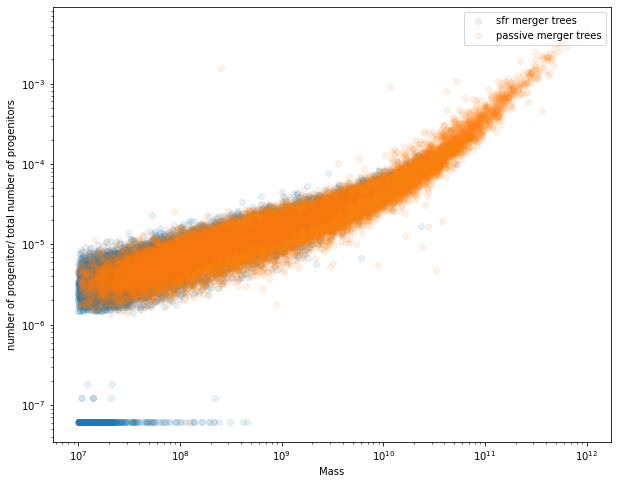

In [7]:
# number of progenitor galaxy as a function of the mass
plt.figure(figsize=(10,8))

num_prog = len_dset[1:len(len_dset)]-len_dset[0:len(len_dset)-1]


num_tot_prog = len_dset[len(len_dset)-1]

print('total number of progenitors = ', num_tot_prog)

#plt.scatter(galaxy_data_remnant[0,:],num_prog, 
#            alpha = 0.5,  label = 'Real merger trees')


ind_ssfr = galaxy_data_remnant[1,:]/galaxy_data_remnant[0,:] > 1e-10

plt.scatter(galaxy_data_remnant[0,ind_ssfr],num_prog[ind_ssfr]/num_tot_prog, 
            alpha = 0.1,  label = 'sfr merger trees')

ind_ssfr = galaxy_data_remnant[1,:]/galaxy_data_remnant[0,:] < 1e-10

plt.scatter(galaxy_data_remnant[0,ind_ssfr],num_prog[ind_ssfr]/num_tot_prog, 
            alpha = 0.1,  label = 'passive merger trees')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass')
plt.ylabel('number of progenitor/ total number of progenitors')
plt.legend(loc = 1)
plt.savefig(destination_out+'/progenitor_vs_mass.pdf', format = 'pdf')
if show_plots == True:
    plt.show()


In [8]:
# here I am defining the binning of the distribution of progenitor galaxy per SFR and per mass
mass_gal_min = 7

num_bins_form = 80
num_bins_host = num_bins_form+1
Mass_gal_bins_form = np.logspace(mass_gal_min, 12, num_bins_form)
print('formation mass bins = \n', Mass_gal_bins_form)
Mass_gal_bins_host = np.logspace(mass_gal_min, 12, num_bins_host)

Mass_gal_mid_form = mid_creator(Mass_gal_bins_form)

Mass_gal_mid_host = mid_creator(Mass_gal_bins_host)
num_bins_sfr_form = 50
num_bins_sfr_host = num_bins_sfr_form+1
sfr_gal_bins_form = np.logspace(-4,3,num_bins_sfr_form)
sfr_gal_bins_host = np.logspace(-4,3,num_bins_sfr_host)

# I should save at the end Prob in a numpy file 

sfr_gal_bins_form_mid =  mid_creator(sfr_gal_bins_form)
sfr_gal_bins_host_mid = mid_creator(sfr_gal_bins_host)

formation mass bins = 
 [1.00000000e+07 1.15688753e+07 1.33838875e+07 1.54836526e+07
 1.79128445e+07 2.07231465e+07 2.39743497e+07 2.77356261e+07
 3.20870000e+07 3.71210501e+07 4.29448799e+07 4.96823959e+07
 5.74769442e+07 6.64943600e+07 7.69264957e+07 8.89953035e+07
 1.02957557e+08 1.19110313e+08 1.37797236e+08 1.59415904e+08
 1.84426271e+08 2.13360453e+08 2.46834047e+08 2.85559230e+08
 3.30359912e+08 3.82189262e+08 4.42149991e+08 5.11517810e+08
 5.91768575e+08 6.84609684e+08 7.92016405e+08 9.16273901e+08
 1.06002585e+09 1.22633068e+09 1.41872667e+09 1.64130720e+09
 1.89880782e+09 2.19670709e+09 2.54134304e+09 2.94004806e+09
 3.40130494e+09 3.93492726e+09 4.55226828e+09 5.26646239e+09
 6.09270466e+09 7.04857404e+09 8.15440740e+09 9.43373222e+09
 1.09137671e+10 1.26260011e+10 1.46068632e+10 1.68984979e+10
 1.95496614e+10 2.26167595e+10 2.61650470e+10 3.02700165e+10
 3.50190046e+10 4.05130497e+10 4.68690419e+10 5.42222101e+10
 6.27289986e+10 7.25703961e+10 8.39557862e+10 9.71274020e+10


[0, 0.05031926929950725, 0.14167420566082, 0.22680547833442688, 0.3182848244905472, 0.4343879371881485, 0.5591485500335693, 0.6754097044467926, 0.800340086221695, 0.9345861077308655, 1.1317265629768372, 1.3730193972587585, 1.611836552619934, 1.8746879696846008, 2.1247235536575317, 2.357725143432617, 2.7474589347839355, 3.2722405195236206, 3.7558200359344482, 4.23443865776062, 4.76122522354126, 5.262326002120972, 5.729288816452026, 6.510364294052124, 7.56209135055542, 8.531245708465576, 9.490454196929932, 12.562672138214111, 17.566165924072266, 22.56965970993042]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2.22044605e-16 1.00638539e-01 1.82709873e-01 2.70901084e-01
 3.65668565e-01 5.03107309e-01 6.15189791e-01 7.35629618e-01
 8.65050554e-01 1.00412166e+00 1.25933146e+00 1.48670733e+00
 1.73696578e+00 2.01241016e+00 2.23703694e+00 2.47841334e+00
 3.01650453e+00 3.52797651e+00 3.98366356e+00 4.48521376e+00
 5.03723669e+00 5.48741531e+00 5.97116232e+00 7.04956627e+00
 8.07

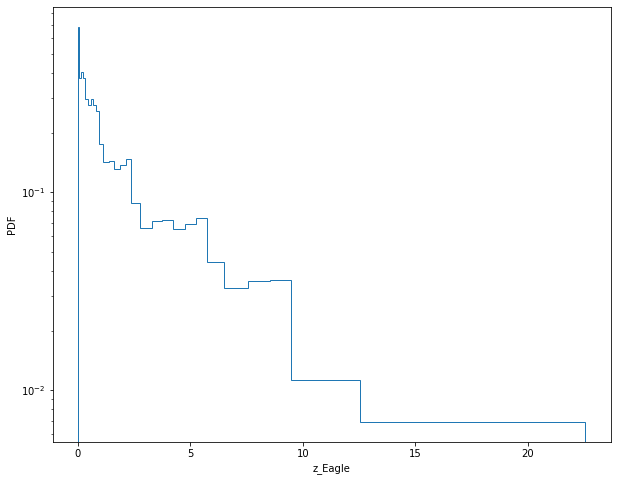

In [9]:
z_Eagle_bins = [0]
for i in range(len(z_Eagle)-1):
    z_Eagle_bins.append(z_Eagle[i]+(z_Eagle[i+1]-z_Eagle[i])/2)
z_Eagle_bins.append(z_Eagle[i+1]+(z_Eagle[i]-z_Eagle[i-1])/2)

print(z_Eagle_bins)

Prob_z = np.histogram(z_Eagle, z_Eagle_bins, density = True)[0]

print(np.histogram(z_Eagle, z_Eagle_bins)[0])

print(z_Eagle)

plt.figure(figsize=(10,8))
plt.hist(z_Eagle,z_Eagle_bins, density = True, histtype = 'step')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('z_Eagle')
if show_plots == True:
    plt.show()

[ 0 13 18] [ 7 23 47] [13 27 34]
No galaxy found with these properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 0.86 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 8.6 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 0.86 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 8.49 SFR$_{form}$ = 8.6 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.01 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 8.6 z$_{form}$ = 0.0
No galaxy found with these properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 8.6 z$_{form}$ = 2.01
No galaxy found with these properties: log(Mass$_{form}$) = 10.01 SFR$_{form}$ = 0.01 z$_{form}$ = 2.01
No galaxy found with these properties: log(Mass$_{form}$) = 7.48 SFR$_{form}$ = 0.86 z$_{form}$ = 3.98
No galaxy found with these properties: log(Mass

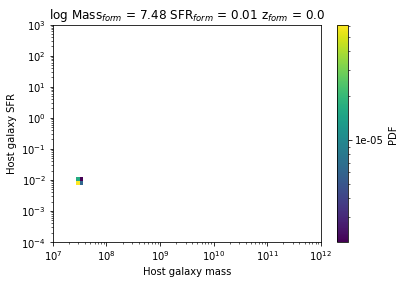

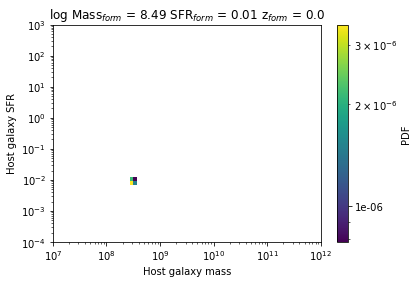

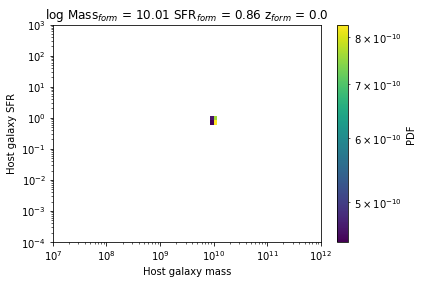

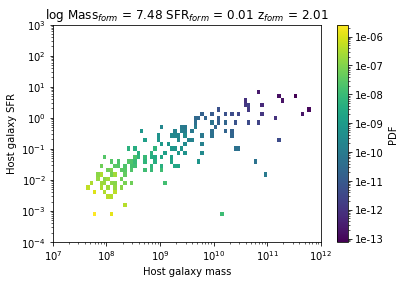

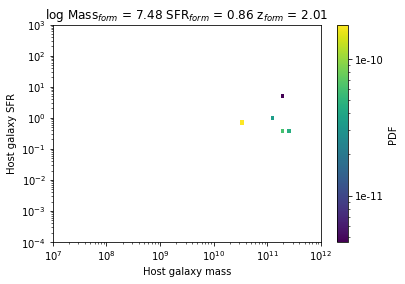

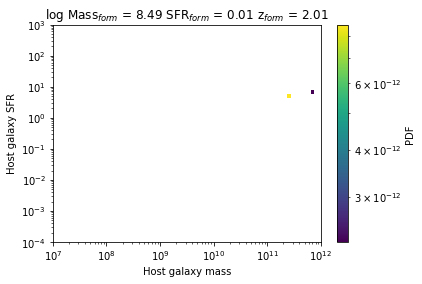

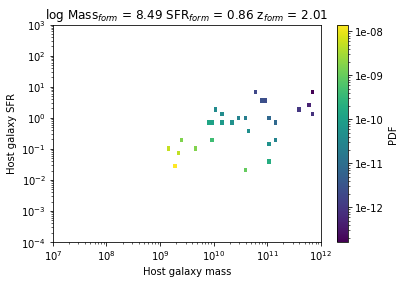

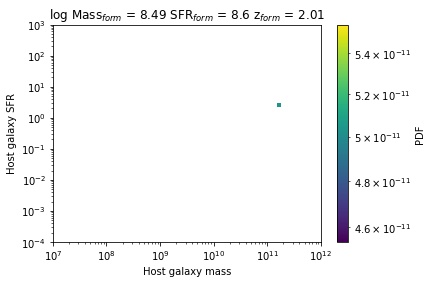

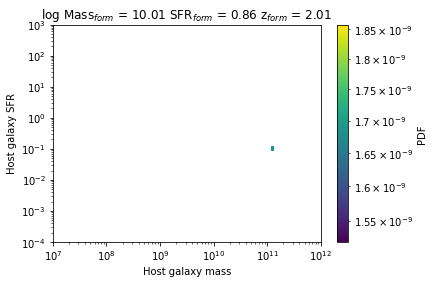

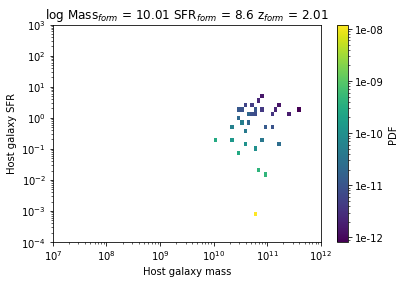

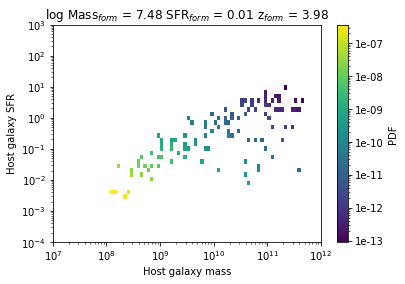

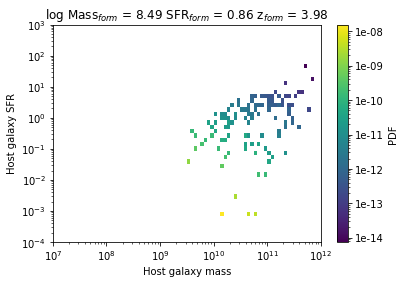

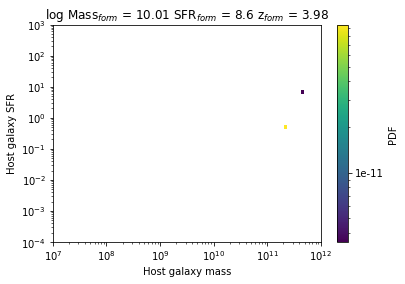

In [10]:
# here I am making some example plots of the conditional probability 
z_form_plot = [0,2,4]
mass_form_plot = [10**(7.5),10**(8.5), 1e10]
sfr_form_plot = [1e-2,1e0,1e1]

z_Eagle_ind = np.zeros(len(z_form_plot), dtype = int)
mass_form_ind = np.zeros(len(mass_form_plot), dtype = int)
sfr_form_ind = np.zeros(len(mass_form_plot), dtype = int)
for t in range(len(z_form_plot)):
    z_Eagle_ind[t] = int(np.argmin(abs(z_Eagle-z_form_plot[t])))
    mass_form_ind[t] = int(np.argmin(abs(Mass_gal_mid_form-mass_form_plot[t])))
    sfr_form_ind[t] = int(np.argmin(abs(sfr_gal_bins_form_mid-sfr_form_plot[t])))
     
print(z_Eagle_ind, mass_form_ind, sfr_form_ind)
for y in range(len(z_Eagle_ind)):
    for i in range(len(mass_form_ind)):
        for k in range(len(sfr_form_ind)):
            #plt.contour(Mass_gal_mid_host,sfr_gal_bins_host_mid, np.transpose(Prob[:,:,
            #        mass_form_ind[i], sfr_form_ind[k],z_Eagle_ind[y]]), levels = 10
                       
            #           )
            
            ind_mass_and_z = np.nonzero((galaxy_data_progenitor[2,:] == z_Eagle[z_Eagle_ind[y]]) & \
             (galaxy_data_progenitor[0,:] <= Mass_gal_bins_form[mass_form_ind[i]+1]) & \
             (galaxy_data_progenitor[0,:] > Mass_gal_bins_form[mass_form_ind[i]]) & \
             (galaxy_data_progenitor[1,:] <= sfr_gal_bins_form[sfr_form_ind[k]+1]) & \
             (galaxy_data_progenitor[1,:] > sfr_gal_bins_form[sfr_form_ind[k]]))[0]
            
            if len(ind_mass_and_z) == 0:
                print('No galaxy found with these properties: log(Mass$_{form}$) = '+ \
                         str(round(np.log10(
                            Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                    ' SFR$_{form}$ = '+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 ' z$_{form}$ = '+str(round(z_Eagle[z_Eagle_ind[y]],2)))
            else:
                plt.figure(figsize=(6,4))
                selected_IDs = np.unique(galaxy_data_progenitor[3,ind_mass_and_z])
                # This should be a bit faster
                ind_ID = np.zeros(len(selected_IDs), dtype = int)
                for d in range(len(selected_IDs)):
                    ind_ID[d] = np.nonzero(galaxy_data_remnant[3,:] == selected_IDs[d])[0]
                host_galaxies_mass = galaxy_data_remnant[0,ind_ID]
                host_galaxies_sfr = galaxy_data_remnant[1,ind_ID]
                plt.hist2d(host_galaxies_mass,host_galaxies_sfr, 
                               bins = [Mass_gal_bins_host,sfr_gal_bins_host],
                               density = True, norm=mpl.colors.LogNorm(), 
                           cmap=cm.viridis)
                plt.title('log Mass$_{form}$ = '+ \
             str(round(np.log10(
                 Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                 ' SFR$_{form}$ = '+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 ' z$_{form}$ = '+str(round(z_Eagle[z_Eagle_ind[y]],2)))
                plt.xlabel('Host galaxy mass')
                plt.ylabel('Host galaxy SFR')
                plt.xscale('log')
                plt.yscale('log')
                formatter = LogFormatter(10, labelOnlyBase=False) 
                plt.colorbar(label="PDF", format=formatter)
                
                plt.savefig(destination_out+'/probability_plots/cond_prob_logM_form_'+ \
             str(round(np.log10(
                 Mass_gal_mid_form[mass_form_ind[i]]),2))+ \
                 '_SFR_form_'+str(round(sfr_gal_bins_form_mid[sfr_form_ind[k]],2))+ \
                 '_z_form_'+str(round(z_Eagle[z_Eagle_ind[y]],2))+'.pdf', format = 'pdf')
                if show_plots == True:
                    plt.show()

In [ ]:
# The probablity depends just on the merger tree,
# It can be evaluated just once
                # host galaxy               # host SFR
Prob = np.zeros((len(Mass_gal_bins_host)-1,len(sfr_gal_bins_host)-1,
                 
                # form galaxy             # SFR form             # formation redshift
                len(Mass_gal_bins_form)-1,len(sfr_gal_bins_form)-1,len(z_Eagle)))


i = 0
for i in range(len(z_Eagle)):
        print('formation redshift = ', z_Eagle[i])
        for y in tqdm(range(len(Mass_gal_bins_form)-1)):
            #print('    formation mass = ', np.log10(Mass_gal_bins_form[y]))
            for z in range(len(sfr_gal_bins_form)-1):
                # here I select all progenitors galaxies that fulfill the conditions 
                # in terms of formation mass and star formation
                ind_mass_and_z = np.nonzero((galaxy_data_progenitor[2,:] == z_Eagle[i]) & \
                            (galaxy_data_progenitor[0,:] <= Mass_gal_bins_form[y+1]) & \
                            (galaxy_data_progenitor[0,:] > Mass_gal_bins_form[y]) & \
                            (galaxy_data_progenitor[1,:] <= sfr_gal_bins_form[z+1]) & \
                            (galaxy_data_progenitor[1,:] > sfr_gal_bins_form[z]))[0]
                #print(ind_mass_and_z)
                if len(ind_mass_and_z) == 0:
                    #print('no elements available')
                    Prob[:,:,y,z,i] = 0
                else:
                    selected_IDs = np.unique(galaxy_data_progenitor[3,ind_mass_and_z])
                    # This should be a bit faster
                    ind_ID = np.zeros(len(selected_IDs), dtype = int)
                    for d in range(len(selected_IDs)):
                        ind_ID[d] = np.nonzero(galaxy_data_remnant[3,:] == selected_IDs[d])[0]
                
                    host_galaxies_mass = galaxy_data_remnant[0,ind_ID]
                    host_galaxies_sfr = galaxy_data_remnant[1,ind_ID]
        
                    pdf_values = np.nan_to_num(
                        np.histogram2d(host_galaxies_mass,host_galaxies_sfr, 
                               bins = [Mass_gal_bins_host,sfr_gal_bins_host],
                               density = True)[0])
                    Prob[:,:,y,z,i] = pdf_values


formation redshift =  2.220446049250313e-16


100%|███████████████████████████████████████████| 79/79 [07:57<00:00,  6.04s/it]


formation redshift =  0.10063853859901428


100%|███████████████████████████████████████████| 79/79 [08:53<00:00,  6.76s/it]


formation redshift =  0.18270987272262573


100%|███████████████████████████████████████████| 79/79 [11:27<00:00,  8.71s/it]


formation redshift =  0.270901083946228


100%|███████████████████████████████████████████| 79/79 [09:52<00:00,  7.49s/it]


formation redshift =  0.36566856503486633


 24%|██████████▎                                | 19/79 [02:54<08:56,  8.95s/it]

In [ ]:
# I should save at the end Prob in a numpy file 
np.savez(destination_out+'/Prob_'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_galaxies+'_'+snapshot+'_'+IMF,Prob)

In [12]:
# always create the python version of this notebook 
!jupyter nbconvert --to script cosmo_2_prob_estimator.ipynb

[NbConvertApp] Converting notebook cosmo_2_prob_estimator.ipynb to script
[NbConvertApp] Writing 15094 bytes to cosmo_2_prob_estimator.py
